In [1]:
import os
import pandas as pd

In [2]:
from numpy.random import normal

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
os.chdir(os.path.join(os.getcwd(),'../../..'))
import ExMAS.main
import ExMAS.utils
from ExMAS.transitize import *

In [ ]:
from ExMAS.transitize.main import stick_private_to_ms

In [6]:
import json
from ExMAS.utils import *

In [7]:
from ExMAS.transitize import visualizations
from ExMAS.transitize import analysis

In [8]:
params = ExMAS.utils.get_config('ExMAS/data/configs/transit.json')  # load the default

In [12]:
inData = analysis.load_results(PATH ='transit_results', EXP_NAME = 'size_{}'.format(1300))

In [10]:
inData.transitize.requests = analysis.PT_utility(inData.transitize.requests, params)

In [ ]:
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph

In [ ]:
inData.skims = DotMap(_dynamic=False)  # skim matrices of the network
inData.skims.dist = inData.skim.copy()  # distance (meters)
inData.skims.ride = inData.skims.dist.divide(params.speeds.ride).astype(int).T  # travel time (seconds)
inData.skims.walk = inData.skims.dist.divide(params.speeds.walk).astype(int).T  # walking time (seconds)

In [ ]:
from ExMAS.main import init_log
params.logger_level = 'WARNING'
inData.logger = init_log(params)

In [ ]:
inData = stick_private_to_ms(inData, params)

In [ ]:
r = inData.transitize.requests
r[r.ride_solution_4 != r.ride_solution_3]

In [ ]:
inData.transitize.rm[inData.transitize.rm.solution_3==1].kind

In [13]:
inData = analysis.make_report(inData)
inData.transitize.report

,0,1,2,3
d2d,NaN,895.000000,837.000000,792.000000
dest_walk_time,0.000000,0.000000,10672.000000,20534.000000
fare,6802.027500,5228.905853,5088.899947,4835.583242
ms,NaN,NaN,NaN,90.000000
nRides,1300.000000,30129.000000,30401.000000,62707.000000
orig_walk_time,0.000000,0.000000,11565.000000,23372.000000
p,1300.000000,405.000000,406.000000,400.000000
s2s,NaN,NaN,57.000000,18.000000
test,1.000000,1.000000,1.000000,1.000000
ttrav,566281.000000,734681.000000,713030.750000,645816.250000


In [14]:
report = inData.transitize.report
report.columns = ['private','door-to-door pooled','stop-to-stop pooled','multi-stop pooled']
compos = report.loc[['p','d2d','s2s','ms']].fillna(0).astype(int).T
compos.columns = ['private','door-to-door pooled','stop-to-stop pooled','multi-stop pooled']
compos.index.name = 'solution'
compos.style.set_caption("Rides composition")

,private,door-to-door pooled,stop-to-stop pooled,multi-stop pooled
solution,,,,
private,1300,0,0,0
door-to-door pooled,405,895,0,0
stop-to-stop pooled,406,837,57,0
multi-stop pooled,400,792,18,90


In [21]:
pd.set_option('precision', 2)
report = report.T
report['walk_time'] = report['orig_walk_time']+report['dest_walk_time']
report = report.T

KPIs = report.loc[['u_veh','u_pax','ttrav','walk_time','nRides', 'fare', 'efficiency','occupancy']].fillna(0).T
for col in ['u_veh','ttrav', 'walk_time']:
    KPIs[col] = (KPIs[col]/3600).round(2)
for col in ['u_pax','nRides', 'fare']:
    KPIs[col] = KPIs[col].astype(int)
for col in ['efficiency','occupancy']:
    KPIs[col] = KPIs[col].round(2)
KPIs.u_veh = KPIs.u_veh
KPIs.columns = ['vehicle hours','travellers costs (utility)','passenger in-vehicle hours',
                'walk time ', 'feasible rides', 'total fare', 
                'fares per veh hours', 'occupancy']

KPIs.index.name = 'solution'
KPIs.style.set_caption("KPIs")

,vehicle hours,travellers costs (utility),passenger in-vehicle hours,walk time,feasible rides,total fare,fares per veh hours,occupancy
solution,,,,,,,,
private,157.30,8796,157.30,0.00,1300,6802,43.24,1.00
door-to-door pooled,102.67,8422,204.08,0.00,30129,5228,50.93,1.53
stop-to-stop pooled,101.81,8360,198.06,6.18,30401,5088,49.98,1.54
multi-stop pooled,100.29,7920,179.39,12.20,62707,4835,48.21,1.57


In [ ]:
requests = inData.transitize.requests
rm = inData.transitize.rm
requests['fare_3'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_3) & (rm.traveller == x.name)].fare.max(), axis = 1)
requests['fare_2'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_2) & (rm.traveller == x.name)].fare.max(), axis = 1)
requests['u_3'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_3) & (rm.traveller == x.name)].u.max(), axis = 1)
requests['u_2'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_2) & (rm.traveller == x.name)].u.max(), axis = 1)
requests['u_1'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_1) & (rm.traveller == x.name)].u.max(), axis = 1)
requests['u_0'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_1) & (rm.traveller == x.name)].u.max(), axis = 1)

In [ ]:
rm[rm.traveller == 888]

In [ ]:
import seaborn as sns

In [ ]:
rm = inData.transitize.rm
rm['u_private'] = rm.apply(lambda x: rm[(rm.kind=='p')& (rm.traveller == x.traveller)].u.max(), axis =1)

In [ ]:
inData.transitize.rides['ttrav_total'] = inData.transitize.rides.apply(lambda x: 
                                                                       inData.transitize.rm[inData.transitize.rm.ride == x.name].ttrav.sum(),axis = 1)

In [ ]:
inData.transitize.rides['occupancy'] = inData.transitize.rides['ttrav_total'] / inData.transitize.rides['u_veh']

In [23]:
import seaborn as sns

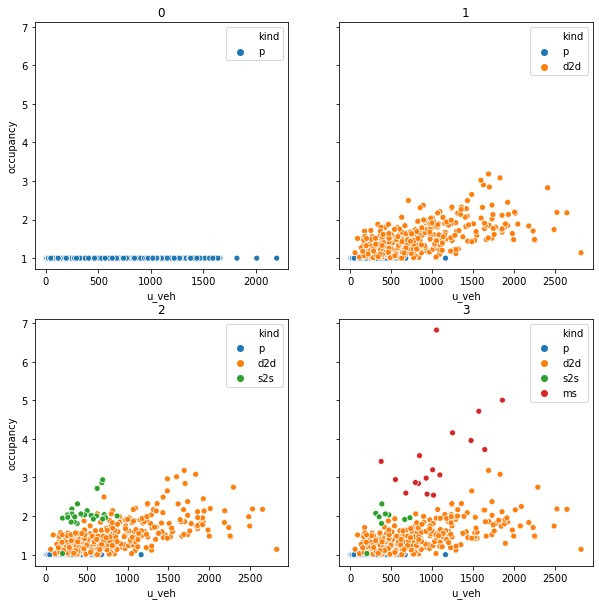

In [24]:
fig, ax = plt.subplots(2,2, figsize = (10,10), sharey = True)
ax = ax.flatten()
for level in [0,1,2,3]:
    solution = inData.transitize.rides[inData.transitize.rides['solution_{}'.format(level)] ==1]
    solution['ttrav_total'] = solution.apply(lambda x: inData.transitize.rm[inData.transitize.rm.ride == x.name].ttrav.sum(),axis = 1)
    solution['occupancy'] = solution['ttrav_total'] / solution['u_veh']
    sns.scatterplot(data = solution, x = 'u_veh', y = 'occupancy', hue = 'kind' , ax = ax[level])
    ax[level].set_title(level)

In [ ]:
solution[solution.u_private<solution.u][['u','u_private', 'ttrav', 'u_']]

In [ ]:
rm['rel_dif'] = (rm.u - rm.u_private ) / rm.u

In [133]:
df = inData.transitize.rm[inData.transitize.rm['solution_{}'.format(3)] ==1]
df['u_private'] = df.apply(lambda x: rm[(rm.traveller == x.traveller) &(rm.kind=='p') ].u.iloc[0], axis =1)
df = df[df.kind=='ms']

In [150]:
def utility_s2s(traveller):
    # utility of shared trip i for all the travellers
    return (params.price * traveller.fare +
            traveller.VoT * 1.1 * (traveller.ttrav + min(300,traveller.delay)) +
            traveller.VoT * 1 * (traveller.orig_walk_time + traveller.dest_walk_time))

In [148]:
df['u_n'] = df.apply(lambda x: utility_s2s(x), axis = 1)

In [149]:
df[df.u_n>df.u_private][['u','u_n','u_private', 'delay']]

,u,u_n,u_private,delay


0
1
2
3


TypeError: <lambda>() got an unexpected keyword argument 'axis'

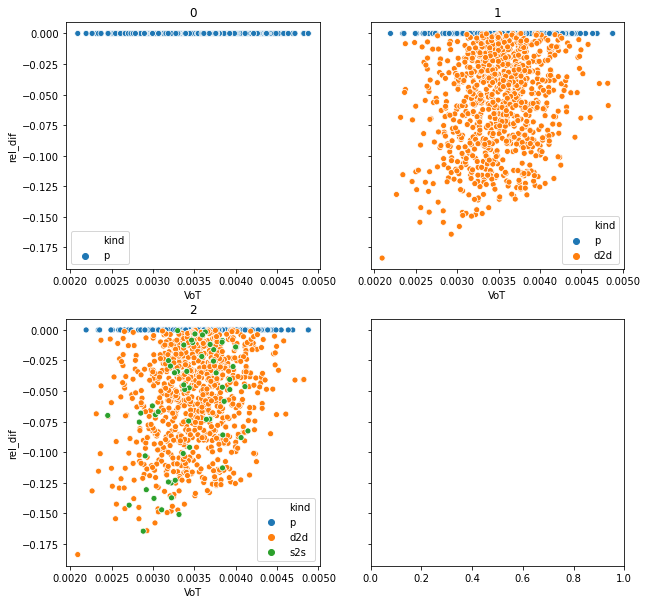

In [27]:
rm = inData.transitize.rm
fig, ax = plt.subplots(2,2, figsize = (10,10), sharey = True)
ax = ax.flatten()
for level in [0,1,2,3]:
    print(level)
    solution = inData.transitize.rm[inData.transitize.rm['solution_{}'.format(level)] ==1]
    solution[solution.kind == 'ms'].u = solution[solution.kind == 'ms'].u.apply(lambda x: utility_s2s(x),axis = 1) 
    solution['u_private'] = solution.apply(lambda x: rm[(rm.kind=='p')& (rm.traveller == x.traveller)].u.max(), axis =1)
    solution['rel_dif'] = (solution.u - solution.u_private ) / solution.u
    sns.scatterplot(data = solution, x = 'VoT', y = 'rel_dif', hue = 'kind' , ax = ax[level])
    ax[level].set_title(level)

In [ ]:
def calc_rm3(inData):
    def calc_deps(r):
        deps = [r.times[0]]
        for d in r.times[1:r.degree]:
            deps.append(deps[-1] + d)  # departure times
        return deps
    ret = list()
    for i,ms in inData.transitize.rides[inData.transitize.rides.kind=='ms'].iterrows():
        ms.degree = len(ms.indexes)
        ms['deps'] = calc_deps(ms)
        ms['indexes_orig'] = json.loads(ms['indexes_orig'])
        ms['indexes_dest'] = json.loads(ms['indexes_dest'])
        ms['high_level_indexes'] = json.loads(ms['high_level_indexes'])    
        df = rm[rm.ride.isin(ms.high_level_indexes)].copy()

        df['s2s_reference'] = df.ride.astype(int).copy()
        df['degree'] = len(ms.indexes)    
        df['ttrav'] = df.apply(lambda x: ms.deps[ms.indexes_dest.index(x.s2s_reference)+len(ms.high_level_indexes)] - ms.deps[ms.indexes_orig.index(x.s2s_reference)], axis = 1)
        df['door_departure'] = df.apply(lambda x: ms.deps[ms.indexes_orig.index(x.s2s_reference)] - x.orig_walk_time, axis = 1)
        df['delay'] = df.apply(lambda x: ms.deps[ms.indexes_orig.index(x.s2s_reference)] - x.orig_walk_time - x.treq, axis = 1)
        ret.append(df)
    df = pd.concat(ret)
    inData.transitize.rm = pd.concat([inData.transitize.rm,df])
    return inData
inData = calc_rm3(inData)

In [ ]:
inData.transitize.rm

In [ ]:
ms = inData.transitize.rides.loc[10522]
ms

In [ ]:
nodes = list(inData.transitize.rides.loc[json.loads(ms.indexes_orig)].origin.astype(int).values) + list(inData.transitize.rides.loc[json.loads(ms.indexes_dest)].destination.astype(int).values)

In [ ]:
for i, node in enumerate(nodes[:-1]):
    print(int(nx.shortest_path_length(inData.G, node, nodes[i+1], weight='length')/params.avg_speed))

In [ ]:
params = ExMAS.utils.get_config('ExMAS/data/configs/transit.json')  # load the default
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph

In [ ]:
inData.transitize.rm

In [ ]:
inData.transitize.rides

In [ ]:
nx.shortest_path_length(inData.G, 46444472, 46418110, weight='length')/params.avg_speed

In [ ]:
inData.transitize.rm.sum()

In [ ]:
inData.transitize.rides[inData.transitize.rides.kind=='s2s']

In [ ]:
solutions = dict()
solution = requests.copy()

solution['u_veh'.format(level)] = solution.apply(lambda x: rides.loc[x.ride_solution_3].u_veh,axis=1)
solution['u_veh'.format(level)] = solution.apply(lambda x: rides.loc[x.ride_solution_3].u_veh,axis=1)

In [ ]:
rides.sample()

In [ ]:
requests[requests.ride_solution_2==501]

In [ ]:
rides[rides.solution_3==1]

In [ ]:
inData.transitize.rm1

In [ ]:
inData.transitize.rm2

In [ ]:
#inData.transitize.rm2['ride_s2s'] = inData.transitize.rm2.apply(lambda x: rides[(rides.d2d_reference == x.ride) & (rides.kind == 's2s')].index[0],axis =1)
inData.transitize.rm2

In [ ]:
rides[rides.kind=='ms']

In [ ]:
inData.transitize.rm2.ride.unique

In [ ]:
inData.transitize.rm1

In [ ]:
rides = inData.transitize.rides
rides[rides.kind=='s2s']

In [ ]:
pd.concat([inData.transitize.rm1,inData.transitize.rm2])

In [ ]:
rides = inData.transitize.rides
requests = inData.transitize.requests

In [ ]:
level = 2


In [ ]:
 = requests.apply(lambda x: )

In [ ]:
inData.transitize.ExMASrides1.shape, inData.transitize.ridesExMAS2.shape

In [ ]:
ride

In [ ]:
ride_index = 9149
rides = inData.transitize.rides
requests = inData.transitize.requests

ride = inData.transitize.rides.loc[ride_index]
try:
    ride['high_level_indexes'] = json.loads(ride['high_level_indexes'])
except:
    pass
ride['origins'] = requests.loc[ride.indexes].origin.values
ride['destinations'] = requests.loc[ride.indexes].destination.values

private_rides = rides[rides.kind=='p'][rides['index'].isin(ride.indexes)]

s2s_rides = rides.loc[ride.high_level_indexes]

d2d_rides = rides.loc[s2s_rides.d2d_reference.values]

In [ ]:
private_rides

In [ ]:
d2d_rides

In [ ]:
s2s_rides

In [ ]:
rides = inData.transitize.rides
rides[(rides.solution_3==1)&(rides.kind=='ms')]